# Recommender Systems
[STUcard](https://www.stucard.ch/) provided us a dump of their productive database. We are required to implement a collaborative recommender system that recommends a suitable deal based on the previous views.

![image.png](attachment:image.png)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.options.display.max_columns = None
from IPython.display import display

from sklearn.decomposition import NMF

%matplotlib inline

c:\python36\lib\distutils\__init__.py:14: UserWarning: The virtualenv distutils package at %s appears to be in the same location as the system distutils?
  warnings.warn("The virtualenv distutils package at %s appears to be in the same location as the system distutils?")


### Load dataset
Our dataset consists of more than 200'000 entries where we can see the amount of times a user has viewed a specific category.

#### Deals

In [416]:
deals = pd.read_csv("deals.csv")
print(deals.shape)
deals.head()

(204355, 3)


,user_id,category_id,views
0,11135,6,1
1,11135,7,3
2,11135,8,9
3,11135,10,7
4,11135,11,1


##### Show some statistics

In [417]:
deals.describe()

,user_id,category_id,views
count,204355.000000,204355.000000,204355.000000
mean,11731.225896,37.717790,2.307411
std,6790.142087,26.556046,2.830939
min,0.000000,1.000000,1.000000
25%,5861.000000,11.000000,1.000000
50%,11693.000000,36.000000,1.000000
75%,17607.000000,60.000000,2.000000
max,23546.000000,111.000000,122.000000


#### Categories
The categories dataframe maps the category id to a name. Our dataset consists of 69 different categories.

In [418]:
categories = pd.read_csv("categories.csv")
print(categories.shape)
categories.head()

(69, 2)


,category_id,name
0,1,Elektronik
1,2,Computer
2,3,Fotografie
3,6,Fashion
4,7,Food


### Movie Dataset

In [455]:
def load_movies_dataset():
    deals = pd.read_csv("ratings.csv")
    deals = deals.rename(columns={"movie_id": "category_id", "rating": "views"})

    categories = pd.read_csv("movies.csv")
    categories = categories.rename(columns={"movie_id": "category_id"})
    categories = categories.head(500)

    deals = deals.merge(categories, on="category_id", how="left")
    deals = deals.dropna(subset=["name"])
    deals = deals[["user_id", "category_id", "views"]]
    
    return categories, deals

categories, deals = load_movies_dataset()
deals.head()

,user_id,category_id,views
25,1,48,5
39,1,150,5
40,1,1,5
44,1,260,4
73,2,434,2


## acostasg

In [457]:
def load_purchase_data(path):
    df = pd.read_csv(path, header=None)
    df.columns = ["date", "user_id", "name"]
    
    categories = pd.DataFrame(data=set(df.name.values), columns=["name"])
    categories["category_id"] = categories.index
    categories.head()
    
    deals = df.merge(categories, on="name", how="left")
    deals = deals[["user_id", "category_id"]]
    
    deals["views"] = 1
    deals = deals.groupby(by=["user_id", "category_id"]).sum().reset_index()
    
    return categories, deals

In [458]:
#categories, deals = load_purchase_data("acostasg.csv")

### Split Dataset
We split the deals into a training and test set. 

In [461]:
train, test = train_test_split(deals, test_size=0.05, random_state=42)
print("train", train.shape)
print("test", test.shape)

train (129588, 3)
test (6821, 3)


In [462]:
test.head()

,user_id,category_id,views
244773,1473,44,2
625569,3780,24,4
322732,1912,52,3
131536,852,260,4
151020,971,110,4


## Load dummy data

In [1]:
deals = pd.read_csv("deals_dummy.csv")
categories = pd.read_csv("categories_dummy.csv")

NameError: name 'pd' is not defined

### Create base class
There does not exist any recommender systems in Scikit-Learn. Therefore we create our own base-class with the usual `fit`, `predict` and `evaluate` methods.

In [463]:
class RecommenderSystem:
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        pass
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int) -> pd.DataFrame:
        pass
    
    def recommend(self, user_to_item_vector: pd.Series, n_recommendations: int, n_neighbors: int):
        pass
        
    def evaluate(self, train: pd.DataFrame, test: pd.DataFrame, n_recommendations:int, n_neighbors=-1, verbose=False) -> pd.DataFrame:
        pass

#### Implement the evaluate method 
We use the minimum precision@k metric to evaluate our recommender system that we are going to build. Note that the evaluation is completely different to what we have seen in the previous lectures. We use our training set to recommend categories and then check if they occur in the test set.

In [464]:
class RecommenderSystem:
    def __min_precision_at_k(self, k, deals, recommendations):
        if len(deals) == 0:
            # this case should not happen!
            return 0
        return len(set(deals) & set(recommendations)) / min(k, len(deals))
    
    def evaluate(self, train: pd.DataFrame, test: pd.DataFrame, n_recommendations:int, n_neighbors=-1, verbose=False) -> pd.DataFrame:
        recommendations = self.predict(train, n_recommendations, n_neighbors)
        
        precisions = []
        for user_id in test.user_id.unique():
            if not user_id in train.user_id:
                # User is not contained in training set
                continue
            rec_categories = recommendations[recommendations.index==user_id].values
            if not len(rec_categories) > 0:
                # nothing could be recommended
                continue
            actual_categories = test[test.user_id==user_id].category_id.values
            precision = self.__min_precision_at_k(n_recommendations, actual_categories, rec_categories[0])
            if verbose:
                print("actual:", actual_categories, "rec:", rec_categories, "->", precision)
            precisions.append(precision)
        
        return np.mean(precisions) 

## Random Recommender

In [465]:
class RandomRecommender(RecommenderSystem):
    def fit(self, deals: pd.DataFrame, categories):
        self.categories = categories
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int =-1) -> pd.DataFrame:
        recommendations = {}
        for user_id in sorted(deals.user_id.unique()):
            recommendations[user_id] = self.categories.sample(n_recommendations).category_id.values
        recommendations = pd.DataFrame(data=recommendations).T
        recommendations.index.name = "user_id"
        return recommendations

In [466]:
n_recommendations = 5

recommender = RandomRecommender()
recommender.fit(train, categories)
recommender.evaluate(train, test, n_recommendations)

0.0062383612662942275

## Item-to-Item Collaborative Filtering
We start by implementing a Item-to-Item collaborative filtering recommender system.

![image.png](attachment:image.png)

### Build User-to-Item Matrix
For both User-to-User and Item-to-Item recommender system we need a User-to-Item matrix. Therefore we implement it in the base class.

In [467]:
class RecommenderSystem(RecommenderSystem):
    def get_user_to_item_matrix(self, deals : pd.DataFrame, categories : pd.DataFrame) -> pd.DataFrame:
        # To make sure that we have all categories in our deals, we add dummy deals for each category
        dummy_user_id = -1
        dummy_deals = [[dummy_user_id, category.category_id, 0] 
                       for category in categories.itertuples()]
        dummy_deals = pd.DataFrame(data=dummy_deals, columns=deals.columns)
        deals = deals.append(dummy_deals, ignore_index=True)

        deals = pd.merge(deals, categories, on='category_id', how="left")
        deals = deals.rename(columns={"name" : "category_name"})

        user_to_item_matrix = pd.pivot_table(
            deals, index=deals.user_id, columns="category_name", 
            values="views", fill_value=0, aggfunc="sum")
        # remove dummy_deal column
        user_to_item_matrix = user_to_item_matrix[user_to_item_matrix.index != dummy_user_id]
        return user_to_item_matrix

In [468]:
user_to_item_matrix_test = RecommenderSystem().get_user_to_item_matrix(test, categories)
print(user_to_item_matrix_test.shape)
user_to_item_matrix_test.head()

(2894, 500)


category_name,8 Seconds (1994),Above the Rim (1994),Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),"Addiction, The (1995)","Adventures of Priscilla, Queen of the Desert, The (1994)","Age of Innocence, The (1993)","Air Up There, The (1994)",Airheads (1994),Amateur (1994),"Amazing Panda Adventure, The (1995)","American President, The (1995)",Angela (1995),Angels and Insects (1995),Anne Frank Remembered (1995),Another Stakeout (1993),Antonia's Line (Antonia) (1995),Apollo 13 (1995),Assassins (1995),"Awfully Big Adventure, An (1995)",Babe (1995),"Baby-Sitters Club, The (1995)","Babysitter, The (1995)",Backbeat (1993),Bad Boys (1995),Bad Company (1995),Bad Girls (1994),Balto (1995),Barcelona (1994),"Basketball Diaries, The (1995)",Batman Forever (1995),Beautiful Girls (1996),Bed of Roses (1996),Before Sunrise (1995),Before and After (1996),Before the Rain (Pred dozhdot) (1994),Being Human (1993),Belle de jour (1967),"Beverly Hillbillies, The (1993)",Beverly Hills Cop III (1994),Beyond Bedlam (1993),Beyond Rangoon (1995),Big Bully (1996),"Big Green, The (1995)",Billy Madison (1995),Bio-Dome (1996),"Birdcage, The (1996)",Bitter Moon (1992),Black Beauty (1994),Black Sheep (1996),Blink (1994),Blown Away (1994),Blue Chips (1994),Blue Sky (1994),Blue in the Face (1995),Body Snatchers (1993),Boomerang (1992),Bottle Rocket (1996),Boxing Helena (1993),Boys Life (1995),"Boys of St. Vincent, The (1993)",Boys on the Side (1995),Braveheart (1995),"Bridges of Madison County, The (1995)",Broken Arrow (1996),"Bronx Tale, A (1993)",Brother Minister: The Assassination of Malcolm X (1994),"Brothers McMullen, The (1995)","Browning Version, The (1994)",Bullets Over Broadway (1994),Burnt By the Sun (Utomlyonnye solntsem) (1994),Bushwhacked (1995),Cabin Boy (1994),Calendar Girl (1993),Canadian Bacon (1994),Carlito's Way (1993),Carrington (1995),Casino (1995),Casper (1995),Castle Freak (1995),Catwalk (1995),Chungking Express (1994),Circle of Friends (1995),City Hall (1996),City Slickers II: The Legend of Curly's Gold (1994),"City of Lost Children, The (1995)",Clean Slate (1994),Clear and Present Danger (1994),Clerks (1994),"Client, The (1994)",Cliffhanger (1993),Clockers (1995),Clueless (1995),Cobb (1994),Coldblooded (1995),"Colonel Chabert, Le (1994)",Color of Night (1994),Coneheads (1993),"Confessional, The (Le Confessionnal) (1995)",Congo (1995),Cops and Robbersons (1994),Copycat (1995),"Corrina, Corrina (1994)","Cowboy Way, The (1994)",Crimson Tide (1995),Crooklyn (1994),"Crossing Guard, The (1995)","Crow, The (1994)",Crumb (1994),"Cry, the Beloved Country (1995)","Cure, The (1995)",Cutthroat Island (1995),Dangerous Game (1993),Dangerous Minds (1995),Dave (1993),Dazed and Confused (1993),Dead Man Walking (1995),Dead Presidents (1995),Death and the Maiden (1994),Demolition Man (1993),Desert Winds (1995),Desperado (1995),Destiny Turns on the Radio (1995),Devil in a Blue Dress (1995),Die Hard: With a Vengeance (1995),Disclosure (1994),Dolores Claiborne (1994),Don Juan DeMarco (1995),Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996),"Doom Generation, The (1995)",Double Happiness (1994),Down Periscope (1996),Dracula: Dead and Loving It (1995),Dream Man (1995),Drop Zone (1994),Dumb & Dumber (1994),Dunston Checks In (1996),Eat Drink Man Woman (1994),Ed Wood (1994),"Endless Summer 2, The (1994)","Enfer, L' (1994)","Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)",Even Cowgirls Get the Blues (1993),Executive Decision (1996),Exit to Eden (1994),Exotica (1994),Eye for an Eye (1996),Fair Game (1995),Fall Time (1995),Far From Home: The Adventures of Yellow Dog (1995),Farewell My Concubine (1993),Farinelli: il castrato (1994),Faster Pussycat! Kill! Kill! (1965),Fatal Instinct (1993),Father of the Bride Part II (1995),"Favor, The (1994)",Fear of a Black Hat (1993),"Fear, The (1995)",Fearless (1993),Feast of July (1995),Federal Hill (19

In [469]:
user_to_item_matrix = RecommenderSystem().get_user_to_item_matrix(train, categories)

print(user_to_item_matrix.shape)
user_to_item_matrix.head()

(5872, 500)


category_name,8 Seconds (1994),Above the Rim (1994),Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),"Addiction, The (1995)","Adventures of Priscilla, Queen of the Desert, The (1994)","Age of Innocence, The (1993)","Air Up There, The (1994)",Airheads (1994),Amateur (1994),"Amazing Panda Adventure, The (1995)","American President, The (1995)",Angela (1995),Angels and Insects (1995),Anne Frank Remembered (1995),Another Stakeout (1993),Antonia's Line (Antonia) (1995),Apollo 13 (1995),Assassins (1995),"Awfully Big Adventure, An (1995)",Babe (1995),"Baby-Sitters Club, The (1995)","Babysitter, The (1995)",Backbeat (1993),Bad Boys (1995),Bad Company (1995),Bad Girls (1994),Balto (1995),Barcelona (1994),"Basketball Diaries, The (1995)",Batman Forever (1995),Beautiful Girls (1996),Bed of Roses (1996),Before Sunrise (1995),Before and After (1996),Before the Rain (Pred dozhdot) (1994),Being Human (1993),Belle de jour (1967),"Beverly Hillbillies, The (1993)",Beverly Hills Cop III (1994),Beyond Bedlam (1993),Beyond Rangoon (1995),Big Bully (1996),"Big Green, The (1995)",Billy Madison (1995),Bio-Dome (1996),"Birdcage, The (1996)",Bitter Moon (1992),Black Beauty (1994),Black Sheep (1996),Blink (1994),Blown Away (1994),Blue Chips (1994),Blue Sky (1994),Blue in the Face (1995),Body Snatchers (1993),Boomerang (1992),Bottle Rocket (1996),Boxing Helena (1993),Boys Life (1995),"Boys of St. Vincent, The (1993)",Boys on the Side (1995),Braveheart (1995),"Bridges of Madison County, The (1995)",Broken Arrow (1996),"Bronx Tale, A (1993)",Brother Minister: The Assassination of Malcolm X (1994),"Brothers McMullen, The (1995)","Browning Version, The (1994)",Bullets Over Broadway (1994),Burnt By the Sun (Utomlyonnye solntsem) (1994),Bushwhacked (1995),Cabin Boy (1994),Calendar Girl (1993),Canadian Bacon (1994),Carlito's Way (1993),Carrington (1995),Casino (1995),Casper (1995),Castle Freak (1995),Catwalk (1995),Chungking Express (1994),Circle of Friends (1995),City Hall (1996),City Slickers II: The Legend of Curly's Gold (1994),"City of Lost Children, The (1995)",Clean Slate (1994),Clear and Present Danger (1994),Clerks (1994),"Client, The (1994)",Cliffhanger (1993),Clockers (1995),Clueless (1995),Cobb (1994),Coldblooded (1995),"Colonel Chabert, Le (1994)",Color of Night (1994),Coneheads (1993),"Confessional, The (Le Confessionnal) (1995)",Congo (1995),Cops and Robbersons (1994),Copycat (1995),"Corrina, Corrina (1994)","Cowboy Way, The (1994)",Crimson Tide (1995),Crooklyn (1994),"Crossing Guard, The (1995)","Crow, The (1994)",Crumb (1994),"Cry, the Beloved Country (1995)","Cure, The (1995)",Cutthroat Island (1995),Dangerous Game (1993),Dangerous Minds (1995),Dave (1993),Dazed and Confused (1993),Dead Man Walking (1995),Dead Presidents (1995),Death and the Maiden (1994),Demolition Man (1993),Desert Winds (1995),Desperado (1995),Destiny Turns on the Radio (1995),Devil in a Blue Dress (1995),Die Hard: With a Vengeance (1995),Disclosure (1994),Dolores Claiborne (1994),Don Juan DeMarco (1995),Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996),"Doom Generation, The (1995)",Double Happiness (1994),Down Periscope (1996),Dracula: Dead and Loving It (1995),Dream Man (1995),Drop Zone (1994),Dumb & Dumber (1994),Dunston Checks In (1996),Eat Drink Man Woman (1994),Ed Wood (1994),"Endless Summer 2, The (1994)","Enfer, L' (1994)","Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)",Even Cowgirls Get the Blues (1993),Executive Decision (1996),Exit to Eden (1994),Exotica (1994),Eye for an Eye (1996),Fair Game (1995),Fall Time (1995),Far From Home: The Adventures of Yellow Dog (1995),Farewell My Concubine (1993),Farinelli: il castrato (1994),Faster Pussycat! Kill! Kill! (1965),Fatal Instinct (1993),Father of the Bride Part II (1995),"Favor, The (1994)",Fear of a Black Hat (1993),"Fear, The (1995)",Fearless (1993),Feast of July (1995),Federal Hill (19

### Build Item-to-Item weight matrix

Now we implement the Item-to-Item weight matrix. To do so, we need a similarity measure. We use the well known cosine similarity. We implement it in the base class.

> Implement the cosine similarity

In [470]:
class RecommenderSystem(RecommenderSystem):
    def cosine_similarity(self, v1, v2):
        pass

In [471]:
class RecommenderSystem(RecommenderSystem):
    def cosine_similarity(self, v1, v2):
        sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        return sim

> Implement the code for the item to item matrix.

In [472]:
class ItemToItemRecommenderSystem(RecommenderSystem):
    def get_item_to_item_matrix(self, user_to_item_matrix):
        # START YOUR CODE
    
    
    
        # END YOUR CODE
    
        item_to_item_matrix = item_to_item_matrix.fillna(0)

        return item_to_item_matrix

In [473]:
class ItemToItemRecommenderSystem(RecommenderSystem):
    def get_item_to_item_matrix(self, user_to_item_matrix):
        item_to_item_matrix = [[self.cosine_similarity(p1, p2) 
                      for p1 in user_to_item_matrix.T.values] 
                        for p2 in user_to_item_matrix.T.values]

        item_to_item_matrix = pd.DataFrame(data=item_to_item_matrix,
                                          columns=user_to_item_matrix.columns.values,
                                          index=user_to_item_matrix.columns.values)
        item_to_item_matrix = item_to_item_matrix.fillna(0)

        return item_to_item_matrix

c:\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(500, 500)


,8 Seconds (1994),Above the Rim (1994),Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),"Addiction, The (1995)","Adventures of Priscilla, Queen of the Desert, The (1994)","Age of Innocence, The (1993)","Air Up There, The (1994)",Airheads (1994),Amateur (1994),"Amazing Panda Adventure, The (1995)","American President, The (1995)",Angela (1995),Angels and Insects (1995),Anne Frank Remembered (1995),Another Stakeout (1993),Antonia's Line (Antonia) (1995),Apollo 13 (1995),Assassins (1995),"Awfully Big Adventure, An (1995)",Babe (1995),"Baby-Sitters Club, The (1995)","Babysitter, The (1995)",Backbeat (1993),Bad Boys (1995),Bad Company (1995),Bad Girls (1994),Balto (1995),Barcelona (1994),"Basketball Diaries, The (1995)",Batman Forever (1995),Beautiful Girls (1996),Bed of Roses (1996),Before Sunrise (1995),Before and After (1996),Before the Rain (Pred dozhdot) (1994),Being Human (1993),Belle de jour (1967),"Beverly Hillbillies, The (1993)",Beverly Hills Cop III (1994),Beyond Bedlam (1993),Beyond Rangoon (1995),Big Bully (1996),"Big Green, The (1995)",Billy Madison (1995),Bio-Dome (1996),"Birdcage, The (1996)",Bitter Moon (1992),Black Beauty (1994),Black Sheep (1996),Blink (1994),Blown Away (1994),Blue Chips (1994),Blue Sky (1994),Blue in the Face (1995),Body Snatchers (1993),Boomerang (1992),Bottle Rocket (1996),Boxing Helena (1993),Boys Life (1995),"Boys of St. Vincent, The (1993)",Boys on the Side (1995),Braveheart (1995),"Bridges of Madison County, The (1995)",Broken Arrow (1996),"Bronx Tale, A (1993)",Brother Minister: The Assassination of Malcolm X (1994),"Brothers McMullen, The (1995)","Browning Version, The (1994)",Bullets Over Broadway (1994),Burnt By the Sun (Utomlyonnye solntsem) (1994),Bushwhacked (1995),Cabin Boy (1994),Calendar Girl (1993),Canadian Bacon (1994),Carlito's Way (1993),Carrington (1995),Casino (1995),Casper (1995),Castle Freak (1995),Catwalk (1995),Chungking Express (1994),Circle of Friends (1995),City Hall (1996),City Slickers II: The Legend of Curly's Gold (1994),"City of Lost Children, The (1995)",Clean Slate (1994),Clear and Present Danger (1994),Clerks (1994),"Client, The (1994)",Cliffhanger (1993),Clockers (1995),Clueless (1995),Cobb (1994),Coldblooded (1995),"Colonel Chabert, Le (1994)",Color of Night (1994),Coneheads (1993),"Confessional, The (Le Confessionnal) (1995)",Congo (1995),Cops and Robbersons (1994),Copycat (1995),"Corrina, Corrina (1994)","Cowboy Way, The (1994)",Crimson Tide (1995),Crooklyn (1994),"Crossing Guard, The (1995)","Crow, The (1994)",Crumb (1994),"Cry, the Beloved Country (1995)","Cure, The (1995)",Cutthroat Island (1995),Dangerous Game (1993),Dangerous Minds (1995),Dave (1993),Dazed and Confused (1993),Dead Man Walking (1995),Dead Presidents (1995),Death and the Maiden (1994),Demolition Man (1993),Desert Winds (1995),Desperado (1995),Destiny Turns on the Radio (1995),Devil in a Blue Dress (1995),Die Hard: With a Vengeance (1995),Disclosure (1994),Dolores Claiborne (1994),Don Juan DeMarco (1995),Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996),"Doom Generation, The (1995)",Double Happiness (1994),Down Periscope (1996),Dracula: Dead and Loving It (1995),Dream Man (1995),Drop Zone (1994),Dumb & Dumber (1994),Dunston Checks In (1996),Eat Drink Man Woman (1994),Ed Wood (1994),"Endless Summer 2, The (1994)","Enfer, L' (1994)","Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)",Even Cowgirls Get the Blues (1993),Executive Decision (1996),Exit to Eden (1994),Exotica (1994),Eye for an Eye (1996),Fair Game (1995),Fall Time (1995),Far From Home: The Adventures of Yellow Dog (1995),Farewell My Concubine (1993),Farinelli: il castrato (1994),Faster Pussycat! Kill! Kill! (1965),Fatal Instinct (1993),Father of the Bride Part II (1995),"Favor, The (1994)",Fear of a Black Hat (1993),"Fear, The (1995)",Fearless (1993),Feast of July (1995),Federal Hill (1994),"Firm, Th

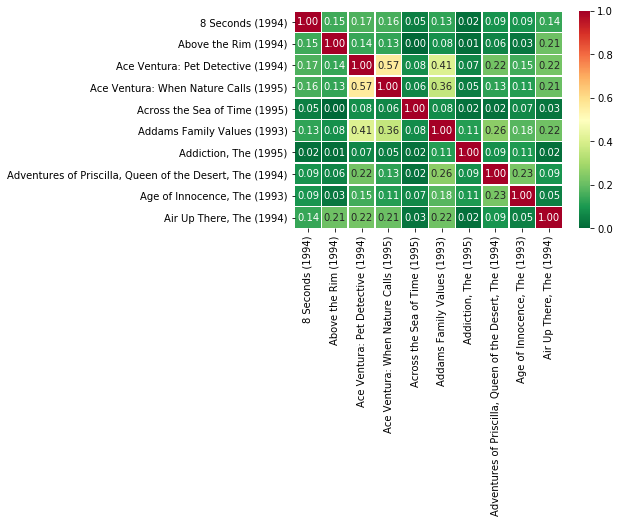

In [474]:
item_to_item_matrix = ItemToItemRecommenderSystem().get_item_to_item_matrix(user_to_item_matrix)

print(item_to_item_matrix.shape)
display(item_to_item_matrix.head())
sns.heatmap(item_to_item_matrix.iloc[0:10, 0:10], annot=True, cmap='RdYlGn_r', linewidths=0.5, fmt='.2f')

### Implement `fit` function

> Store the categories and calculate the user to item and the item to item matrices

In [475]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        # START YOUR CODE
        
        
        # END YOUR CODE
        pass

In [476]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        self.categories = categories
        user_to_item_matrix = self.get_user_to_item_matrix(deals, categories)
        self.item_to_item_matrix = self.get_item_to_item_matrix(user_to_item_matrix)

In [477]:
recommender = ItemToItemRecommenderSystem()
recommender.fit(train, categories)

c:\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


### Implement `predict` function
> Complete the code for the `recommend` functions by calculating the predictions

In [478]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):   
    def recommend(self, user_to_item_vector: pd.Series, n_recommendations: int, n_neighbors: int):
        predictions = []
        for i, view in enumerate(user_to_item_vector):
            if view != 0:
                predictions.append(-1)
                # we are only interested in categories without views.
                continue
            
            # filter for items that have at least one view
            idx = np.where(user_to_item_vector > 0)
            views = user_to_item_vector.values[idx]
            similarities = self.item_to_item_matrix.values[i][idx]
            
            # neighborhood search
            idx_most_similar = similarities.argsort()[::-1][0:n_neighbors]
            views = views[idx_most_similar]
            similarities = similarities[idx_most_similar]

            prediction = np.dot(similarities, views) / np.sum(similarities) \
                if np.sum(similarities) != 0 else 0
            predictions.append(prediction)
        
        predictions = np.array(predictions)
        idx_best_recommendations = predictions.argsort()[::-1][:n_recommendations]
        best_predictions = predictions[idx_best_recommendations]
        return list(zip(idx_best_recommendations, best_predictions))
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int) -> pd.DataFrame:
        user_to_item_matrix = self.get_user_to_item_matrix(deals, self.categories)
        
        all_recommendations = {}
        for user_id in tqdm_notebook(user_to_item_matrix.index):
            user_to_item_vector = user_to_item_matrix[user_to_item_matrix.index == user_id].iloc[0]
            recommendations = self.recommend(user_to_item_vector, n_recommendations, n_neighbors)
            recommendations = [rec[0] for rec in recommendations]
            all_recommendations[user_id] = recommendations

        all_recommendations = pd.DataFrame(data=all_recommendations).T
        all_recommendations.index = user_to_item_matrix.index
        return all_recommendations

Let's test our system by fitting it to the training data and predicting recommendations. We use 10 neighbors.

In [479]:
recommender = ItemToItemRecommenderSystem()
recommender.fit(train, categories)

c:\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [480]:
n_neighbors = 10
n_recommendations = 5

recommender = ItemToItemRecommenderSystem()
recommender.fit(train, categories)

recommendations = recommender.predict(train.iloc[0:50], n_recommendations, n_neighbors)
recommendations.head()

c:\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4
user_id,,,,,
127,499,174,162,163,164
142,264,52,145,363,168
216,499,158,160,161,162
347,438,281,121,180,46
424,499,189,160,161,162


### Evaluate recommender system
To evaluate our recommender system, we calculate the min-precision@k. *This can take a while!*

In [482]:
precision = recommender.evaluate(train, test, n_recommendations, n_neighbors)
precision

0.011452513966480445

## Matrix factorization
Our previous implementation seems to be pretty slow. Let's move to the matrix factorization approach where we transform our user to item matrix into a factorization of two matrices.

![image.png](attachment:image.png)

We will use the [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) class from scikit-learn to decompose a matrix.

In [154]:
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
print("X (Original):\n", "shape:", X.shape, "\n", X)
print(X)

nmf = NMF(n_components=2)
U = nmf.fit_transform(X)
print("\nU:\n", "shape:", U.shape, "\n", U)

V = nmf.components_
print("\nV:\n", "shape:", V.shape, "\n", V)

X_reconstruced = np.dot(U, V)
print("\nX (Reconstructed)\n", "shape:", X_reconstruced.shape, "\n", X_reconstruced)

X (Original):
 shape: (6, 2) 
 [[1.  1. ]
 [2.  1. ]
 [3.  1.2]
 [4.  1. ]
 [5.  0.8]
 [6.  1. ]]
[[1.  1. ]
 [2.  1. ]
 [3.  1.2]
 [4.  1. ]
 [5.  0.8]
 [6.  1. ]]

U:
 shape: (6, 2) 
 [[0.32443996 0.67423514]
 [0.64888098 0.5457934 ]
 [0.97332179 0.57788704]
 [1.29776303 0.28890993]
 [1.62219846 0.        ]
 [1.94664507 0.03202646]]

V:
 shape: (2, 2) 
 [[3.0822296  0.49319405]
 [0.         1.24585037]]

X (Reconstructed)
 shape: (6, 2) 
 [[0.99999846 1.00000795]
 [2.00000018 1.00000115]
 [3.00000125 1.1999973 ]
 [4.00000362 0.99998755]
 [4.99998811 0.80005863]
 [6.00000707 0.99997394]]


### Implement the Matrix Factorization Recommender System

> Complete the code for the `predict` function. To ensure reproducability, use seed 0.

In [155]:
class MatrixFactorizationRecommenderSystem(RecommenderSystem):   
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        self.categories = categories
        
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int = -1) -> pd.DataFrame:
        user_to_item_matrix = self.get_user_to_item_matrix(deals, categories)
        
        X = user_to_item_matrix.values
        
        # START YOUR CODE
        # Decompose the matrix X into two matrices U and V
        # U = ...
        # V = ...
        
        # Reconstruct the matrix X
        # X_reconstruced = ...
        # END YOUR CODE

        recommendations = []
        for rec, x in zip(X_reconstruced, X):
            rec = rec[x == 0].argsort()[::-1][:n_recommendations]
            recommendations.append(rec)
        
        recommendations = pd.DataFrame(data=recommendations)
        recommendations.index = user_to_item_matrix.index
        return recommendations
        

In [156]:
class MatrixFactorizationRecommenderSystem(RecommenderSystem):   
    def fit(self, deals: pd.DataFrame, categories: pd.DataFrame):
        self.categories = categories
        
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int = -1) -> pd.DataFrame:
        user_to_item_matrix = self.get_user_to_item_matrix(deals, self.categories)
        
        X = user_to_item_matrix.values
        nmf = NMF(n_recommendations, random_state=0)
        U = nmf.fit_transform(X)
        V = nmf.components_
        X_reconstruced = np.dot(U, V)
        
        recommendations = []
        for rec, x in zip(X_reconstruced, X):
            rec = rec[x == 0].argsort()[::-1][:n_recommendations]
            recommendations.append(rec)
            
        recommendations = pd.DataFrame(data=recommendations)
        recommendations.index = user_to_item_matrix.index
        return recommendations
        

In [157]:
n_recommendations = 5
recommender = MatrixFactorizationRecommenderSystem()
recommender.fit(train, categories)

recommendations = recommender.predict(test, n_recommendations)
recommendations.head()

,0,1,2,3,4
user_id,,,,,
1,29,25,16,22,12
2,21,12,20,13,2
3,5,11,9,4,31
4,23,10,8,4,32
5,21,12,20,13,2


#### Evaluate it

In [158]:
recommender.evaluate(train, test, n_recommendations)

0.1402560763888889

## Assignment
Now open the ILIAS quiz  and answer the questions.

> Given a user who is interested in *Computer*, *Bar* and *Hotels*. Using our matrix factorization recommedner system, what categories would you recommend?

In [149]:
user = pd.DataFrame(data={
    "user_id": [1, 1, 1],
    "category_id": categories[categories["name"].isin(["Computer", "Bar", "Hotels"])].category_id.values,
    "views": [1, 1, 1]
})
user

ValueError: arrays must all be same length

In [150]:
recommender.predict(user, n_recommendations=3)

NameError: name 'user' is not defined

In [ ]:
categories[categories["category_id"].isin([64, 31, 29])]

## Baseline

Our item-to-item collaborative filtering and our matrix factorization approaches achieve a precision@k of about 5%.

Let's compare it with a baseline that always returns the categories with the most views.

> Implement a baseline recommender that always returns the categories with the most views.

In [151]:
class TopN(RecommenderSystem):
    def fit(self, deals: pd.DataFrame):
        sum_categories = deals.groupby("category_id").sum().views
        self.top_categories = sum_categories.argsort()[::-1].values
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int =-1) -> pd.DataFrame:
        top_n_categories = self.top_categories[:n_recommendations]
        recommendations = {}
        for user_id in sorted(deals.user_id.unique()):
            recommendations[user_id] = top_n_categories
        recommendations = pd.DataFrame(data=recommendations).T
        recommendations.index.name = "user_id"
        return recommendations

In [152]:
recommender = TopN()

recommender.fit(train)

recommendations = recommender.predict(test, n_recommendations)
recommendations.head()

,0,1,2,3,4
user_id,,,,,
1,36,21,35,13,18
2,36,21,35,13,18
3,36,21,35,13,18
4,36,21,35,13,18
5,36,21,35,13,18


In [153]:
recommender.evaluate(train, test, n_recommendations)

0.14908854166666666

Okay, this proves that our implemented recommender systems are useless for the STUcard dataset. But you might ask yourself why?

1. We have implemented a recommender system that works with explicit data such as ratings or likes.
1. The STUcard dataset does not contain any explicit data but only page views (implicit data)
1. If we would like to use our recommender system for implicit data, we would have to somehow transform our data. Have a look at the paper *Collaborative Filtering for Implicit Feedback Datasets* from Hu et al. (http://yifanhu.net/PUB/cf.pdf)

### Data Quality Assessment

In [ ]:
deals["views"].plot(kind="box")

In [ ]:
categories_per_user = deals.groupby("user_id").agg({"category_id": "count"}).reset_index()
categories_per_user.columns = ["user", "#categories"]

users_per_category = deals.groupby("category_id").agg({"user_id": "count"}).reset_index()
users_per_category.columns = ["category", "#users"]

fig, ax = plt.subplots(2, 2, figsize=(10,10))  # 1 row, 2 columns

ax[0,0].hist(categories_per_user['#categories'], bins=np.linspace(0, 100, 50), alpha=0.75)
ax[0,0].set_title('Categories per User')
ax[0,1].boxplot(categories_per_user['#categories'])
ax[0,1].set_title('Categories per User')


ax[1,0].hist(users_per_category['#users'], bins=np.linspace(0, 8000, 40), alpha=0.75)
ax[1,0].set_title('Users per Category')
ax[1,1].boxplot(users_per_category['#users'])
ax[1,1].set_title('Users per Category')

It looks like our data is highly unbalanced. Building a item-to-item collborative filtering recommender seems not be so easy with this dataset.

That's it for the topic of recommender systems. I hope we reminded you that it is very important to do the data quality assessment before starting with the implementation.

## Dummy Dataset

In [395]:
class ItemToItemRecommenderSystem(ItemToItemRecommenderSystem):   
    def recommend(self, user_to_item_vector: pd.Series, n_recommendations: int, n_neighbors: int):
        predictions = []
        for i, view in enumerate(user_to_item_vector):
            if view != 0:
                predictions.append(-1)
                # we are only interested in categories without views.
                continue
            
            # filter for items that have at least one view
            idx = np.where(user_to_item_vector > 0)
            views = user_to_item_vector.values[idx]
            similarities = self.item_to_item_matrix.values[i][idx]
            
            idx_most_similar = similarities.argsort()[::-1][0:n_neighbors]
            views_most_similar = views[idx_most_similar]
            similarities = similarities[idx_most_similar]


            prediction = np.dot(similarities, (views_most_similar)) / np.sum(similarities) \
                if np.sum(similarities) != 0 else 0
            predictions.append(prediction)
        
        predictions = np.array(predictions)
        idx_best_recommendations = predictions.argsort()[::-1][:n_recommendations]
        best_predictions = predictions[idx_best_recommendations]
        return list(zip(idx_best_recommendations, best_predictions))
    
    def predict(self, deals: pd.DataFrame, n_recommendations: int, n_neighbors: int) -> pd.DataFrame:
        user_to_item_matrix = self.get_user_to_item_matrix(deals, self.categories)
        
        all_recommendations = {}
        for user_id in tqdm_notebook(user_to_item_matrix.index):
            user_to_item_vector = user_to_item_matrix[user_to_item_matrix.index == user_id].iloc[0]
            recommendations = self.recommend(user_to_item_vector, n_recommendations, n_neighbors)
            recommendations = [rec[0] for rec in recommendations]
            all_recommendations[user_id] = recommendations

        all_recommendations = pd.DataFrame(data=all_recommendations).T
        all_recommendations.index = user_to_item_matrix.index
        return all_recommendations

category_name,A,B,C,D,E,F
user_id,,,,,,
1,4,3,0,0,5,0
2,5,0,4,0,4,0
3,4,0,5,3,4,0
4,0,3,0,0,0,5
5,0,4,0,0,0,4
6,0,0,2,4,0,5


[(3, 4.5), (2, 4.473684210526316), (5, 3.0)]

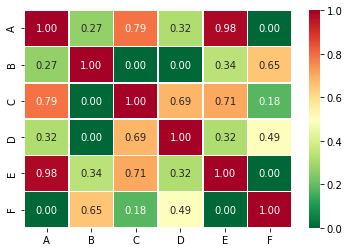

In [396]:
d = pd.read_csv("deals_dummy.csv")
c = pd.read_csv("categories_dummy.csv")

r = ItemToItemRecommenderSystem()
user_to_item_matrix = r.get_user_to_item_matrix(d, c)

display(user_to_item_matrix)

item_to_item_matrix = r.get_item_to_item_matrix(user_to_item_matrix)
item_to_item_matrix
sns.heatmap(item_to_item_matrix, annot=True, cmap='RdYlGn_r', linewidths=0.5, fmt='.2f')

r.fit(d, c)
rec = r.recommend(user_to_item_matrix.iloc[0], n_recommendations=3, n_neighbors=3)
rec

Rating that user 1 would give to book D

In [370]:
(0.32 * 5 + 0.32 * 4) / (0.32 + 0.32)

4.5

Rating that user 1 would give to book C

In [367]:
(0.71 * 5 + 0.79 * 4)/(0.71 + 0.79)

4.473333333333334

Rating, that user 1 would give to book F

In [366]:
(0.65 * 3)/0.65

3.0

Check

In [378]:
rec = r.recommend(user_to_item_matrix.iloc[0], n_recommendations=3, n_neighbors=3)
rec

[(2, 2.684652171766797), (5, 0.9145020732047531), (3, 0.0)]